# League of Legends: Evaluating individual ranked performance and in-game variables

League of Legends (LoL) is the [most popular](https://newzoo.com/insights/rankings/top-20-core-pc-games/) online game in the world. With an active player base of over [80 million monthly players](https://www.unrankedsmurfs.com/blog/players-2017), the multiplayer online battle arena (or MOBA, for short) has continued to grow since its inception in 2011. Much of it's popularity stems from its replayability and competitive match-making system; players fight 5v5 battles on the same map using various strategies in an effort to improve their 'rank.' 

Each League of Legends match is packed with individual and team-level data that helps capture each players' mechanical and decision-making abilities. While the data may miss some of the more nuanced elements of gameplay, we can still use it to highlight individual strengths and weaknesses, which can, in turn, be used to improve performance. For reference, players can be ranked based on their skill-level (low to high) using the following system: Bronze - Silver - Gold - Platinum - Diamond - Master/Challenger.

This notebook provides users an opportunity to access and evaluate their individual-level performances using data retrieved from the Riot API. While much of it is dedicated to data retrival and cleaning, I've included some surface level statistical analysis as well. Moreover, users may freely alter the code to perform deeper statistical analysis as they see fit. Personally, I plan on expanding this notebook to explore machine learning methods to predict match performances and outcomes. 

Currently, the following cells are set to retrieve data from my own account using my personal API key (which has been hidden from public view). However, the 'account_name' variable may be altered to retrieve data from any NA account. To do so, you'll need to request your own development API key from their [developer site](https://developer.riotgames.com/).

In [7]:
import requests
import pandas as pd
import numpy as np

a_token = ''

## Retriving account info from the Riot API

In [8]:
# To acquire the account ID for the desired account, simply pass in the summoner name as a string through 'account_name.'

account_name = 'tinyShanks'
account_info = requests.get('https://na1.api.riotgames.com/lol/summoner/v3/summoners/by-name/'+account_name+'?api_key='+a_token)
account_info = account_info.json()
account_info

{'accountId': 39390294,
 'id': 24913984,
 'name': 'tinyShanks',
 'profileIconId': 1110,
 'revisionDate': 1520147671000,
 'summonerLevel': 52}

In [9]:
IDnum = str(account_info['accountId'])
matches = requests.get('https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/'+IDnum+'?queue=420&api_key='+a_token)
matches = matches.json()['matches']

## Retrieving match history information

Due to Riot's API rate limiting - 100 calls per 1 second - data retrieval must happen in two separate steps (see the following two code cells). Each cell **must** be run with an approximately 10 second interval in between to avoid retrieval errors.

In [10]:
m_hist = pd.DataFrame(matches)
m_ids = m_hist['gameId']

m_id1 = m_ids[:50]
m_id2 = m_ids[50:]

In [5]:
data1 = []
for mid in m_id1:
    match = str(mid)
    full = requests.get('https://na1.api.riotgames.com/lol/match/v3/matches/'+match+'?api_key='+a_token).json()
    data1.append(full)

In [11]:
data2 = []
for mid in m_id2:
    match = str(mid)
    full = requests.get('https://na1.api.riotgames.com/lol/match/v3/matches/'+match+'?api_key='+a_token).json()
    data2.append(full)

In [12]:
# Combine the two .json lists into one; check for retrieval errors. If the cell returns an error, you need to re-run one or both of the above cells at a longer interval.

data = data1 + data2
data[99]['gameId']

2603489543

## Prepping the data for pandas

This section removes and/or alters columns that I personally found less useful for data analysis. Feel free to alter this as you see fit.

In [13]:
# Remove columns that aren't useful for data analysis

selected_columns = list(data[0].keys())
to_rmv = ['mapId','platformId','gameCreation','queueId','gameMode','gameType']
for label in to_rmv:
    selected_columns.remove(label)
selected_columns

['gameId',
 'gameDuration',
 'seasonId',
 'gameVersion',
 'teams',
 'participants',
 'participantIdentities']

In [14]:
# First round of prep

selected_data = []
for i in data:
    m = {}
    for label in selected_columns:
        m[label] = i[label]
    selected_data.append(m)

In [15]:
to_fix = ['teams','participants','participantIdentities']
for label in to_fix:
    selected_columns.remove(label)
selected_columns

['gameId', 'gameDuration', 'seasonId', 'gameVersion']

In [18]:
# Second round of prep and data cleaning

my_data = []
for match in selected_data:
    match_data = {}
    
    for col in selected_columns:
        match_data[col] = match[col]
    
    for pt in match['participantIdentities']:
        if pt['player']['summonerName'] == account_name:
            pid = pt['participantId']
            
    for each in match['participants']:
        if each['participantId'] == pid:
            team_id = each['teamId']
            match_data['Champion'] = each['championId']
            match_data['Kills'] = each['stats']['kills']
            match_data['Deaths'] = each['stats']['deaths']
            match_data['Assists'] = each['stats']['assists']
            match_data['Objective Dmg'] = each['stats']['damageDealtToObjectives']
            match_data['CS'] = each['stats']['totalMinionsKilled']
            match_data['Vision Score'] = each['stats']['visionScore']
            
            if 'creepsPerMinDeltas' in each['timeline']:
                cs = each['timeline']['creepsPerMinDeltas'].values()
                avg_cs = sum(cs)/len(cs)
                match_data['Avg CS/min'] = avg_cs
            else:
                match_data['Avg CS/min'] = np.nan
        
            
            if 'xpPerMinDeltas' in each['timeline']:
                xp = each['timeline']['xpPerMinDeltas'].values()
                avg_xp = sum(cs)/len(cs)
                match_data['Avg XP/min'] = avg_xp
            else:
                match_data['Avg XP/min'] = np.nan
            
            if 'goldPerMinDeltas' in each['timeline']:
                xp = each['timeline']['goldPerMinDeltas'].values()
                avg_g = sum(cs)/len(cs)
                match_data['Avg Gold/min'] = avg_g
            else:
                match_data['Avg Gold/min'] = np.nan
                    
            if each['stats']['win'] == True:
                match_data['Outcome'] = 'Win'
            else:
                match_data['Outcome'] = 'Loss'

    for tm in match['teams']:
        if tm['teamId'] == team_id:
            match_data['Dragons Killed'] = tm['dragonKills']
            match_data['Barons Killed'] = tm['baronKills']
            match_data['Towers Destroyed'] = tm['towerKills']
            match_data['Inhibitors Destroyed'] = tm['inhibitorKills']
            
            if tm['firstBlood'] == True:
                match_data['First blood?'] = 'Yes'
            else:
                match_data['First blood?'] = 'No'
            
            if tm['firstTower'] == True:
                match_data['First tower?'] = 'Yes'
            else:
                match_data['First tower?'] = 'No'
        else:
            match_data['Dragons Lost'] = tm['dragonKills']
            match_data['Barons Lost'] = tm['baronKills']
            match_data['Towers Lost'] = tm['towerKills']
            match_data['Inhibitors Lost'] = tm['inhibitorKills']
            
    my_data.append(match_data)

In [20]:
my_data = pd.DataFrame(my_data)
my_data.head()

,Assists,Avg CS/min,Avg Gold/min,Avg XP/min,Barons Killed,Barons Lost,CS,Champion,Deaths,Dragons Killed,...,Kills,Objective Dmg,Outcome,Towers Destroyed,Towers Lost,Vision Score,gameDuration,gameId,gameVersion,seasonId
0,9,6.95,6.95,6.95,1,0,187,81,3,3,...,5,9962,Win,11,0,26,1717,2732150232,8.4.218.8787,11
1,0,5.70,5.70,5.70,0,0,94,81,6,0,...,1,304,Loss,0,3,9,995,2732074209,8.4.218.8787,11
2,7,5.40,5.40,5.40,0,1,165,42,9,0,...,4,1251,Loss,2,11,14,1921,2732063117,8.4.218.8787,11
3,7,7.25,7.25,7.25,0,0,167,238,2,2,...,18,9154,Win,11,1,27,1739,2731543181,8.4.218.8787,11
4,4,7.40,7.40,7.40,0,0,127,69,3,0,...,0,91,Loss,0,5,18,1104,2731530648,8.4.218.8787,11


In [21]:
# Checking for null values; typically happens for 'Avg x/min' columns

print(my_data.isnull().sum()[my_data.isnull().sum() > 0])
to_drop = my_data[my_data.isnull().any(axis=1)].index

Avg CS/min      1
Avg Gold/min    1
Avg XP/min      1
dtype: int64


In [22]:
# Dropping rows with null values; check if method was successful

my_data = my_data.drop(to_drop)
my_data.isnull().sum()

Assists                 0
Avg CS/min              0
Avg Gold/min            0
Avg XP/min              0
Barons Killed           0
Barons Lost             0
CS                      0
Champion                0
Deaths                  0
Dragons Killed          0
Dragons Lost            0
First blood?            0
First tower?            0
Inhibitors Destroyed    0
Inhibitors Lost         0
Kills                   0
Objective Dmg           0
Outcome                 0
Towers Destroyed        0
Towers Lost             0
Vision Score            0
gameDuration            0
gameId                  0
gameVersion             0
seasonId                0
dtype: int64

In [23]:
# Swap champion IDs for champion names

champions = requests.get('https://na1.api.riotgames.com/lol/static-data/v3/champions?api_key='+a_token)
champion_list = champions.json()

lol_champ_map = {}
for champ in champion_list['data']:
    champ_id = champion_list['data'][champ]['id']
    lol_champ_map[champ_id] = champ 

my_data['Champion'] = my_data['Champion'].map(lol_champ_map)

In [24]:
# Rename/reorder columns within dataframe

my_data['Game ID'] = my_data['gameId']
my_data['Season ID'] = my_data['seasonId']
my_data['Game Version'] = my_data['gameVersion']
my_data['Game Duration (min)'] = my_data['gameDuration']/60

column_reorder = ['Game ID', 'Game Duration (min)', 'Season ID', 'Outcome', 'Champion', 'Kills','Deaths', 'Assists', 'CS', 
                  'Avg CS/min', 'Avg Gold/min', 'Avg XP/min', 'First blood?', 'First tower?', 'Barons Killed',
                  'Barons Lost', 'Dragons Killed','Dragons Lost', 'Inhibitors Destroyed', 'Inhibitors Lost', 
                  'Objective Dmg', 'Towers Destroyed', 'Towers Lost', 'Vision Score','Game Version']

my_data = my_data[column_reorder]
my_data.head()

,Game ID,Game Duration (min),Season ID,Outcome,Champion,Kills,Deaths,Assists,CS,Avg CS/min,...,Barons Lost,Dragons Killed,Dragons Lost,Inhibitors Destroyed,Inhibitors Lost,Objective Dmg,Towers Destroyed,Towers Lost,Vision Score,Game Version
0,2732150232,28.616667,11,Win,Ezreal,5,3,9,187,6.95,...,0,3,0,3,0,9962,11,0,26,8.4.218.8787
1,2732074209,16.583333,11,Loss,Ezreal,1,6,0,94,5.70,...,0,0,1,0,0,304,0,3,9,8.4.218.8787
2,2732063117,32.016667,11,Loss,Corki,4,9,7,165,5.40,...,1,0,3,0,3,1251,2,11,14,8.4.218.8787
3,2731543181,28.983333,11,Win,Zed,18,2,7,167,7.25,...,0,2,0,3,0,9154,11,1,27,8.4.218.8787
4,2731530648,18.400000,11,Loss,Cassiopeia,0,3,4,127,7.40,...,0,0,1,0,0,91,0,5,18,8.4.218.8787


## Most played champion data

In [25]:
most_played_champions = {}
for i,champ in enumerate(list(my_data['Champion'].value_counts().index[0:3])):
    most_played_champions[i+1] = champ
most_played_champions    

{1: 'Teemo', 2: 'Varus', 3: 'Kalista'}

In [26]:
most_played_outcomes = my_data[my_data['Champion']==most_played_champions[1]]['Outcome'].value_counts()
print(most_played_champions[1]+':',(most_played_outcomes['Win']/most_played_outcomes.sum())*100)

Teemo: 68.75


## Factors that affect match outcome

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

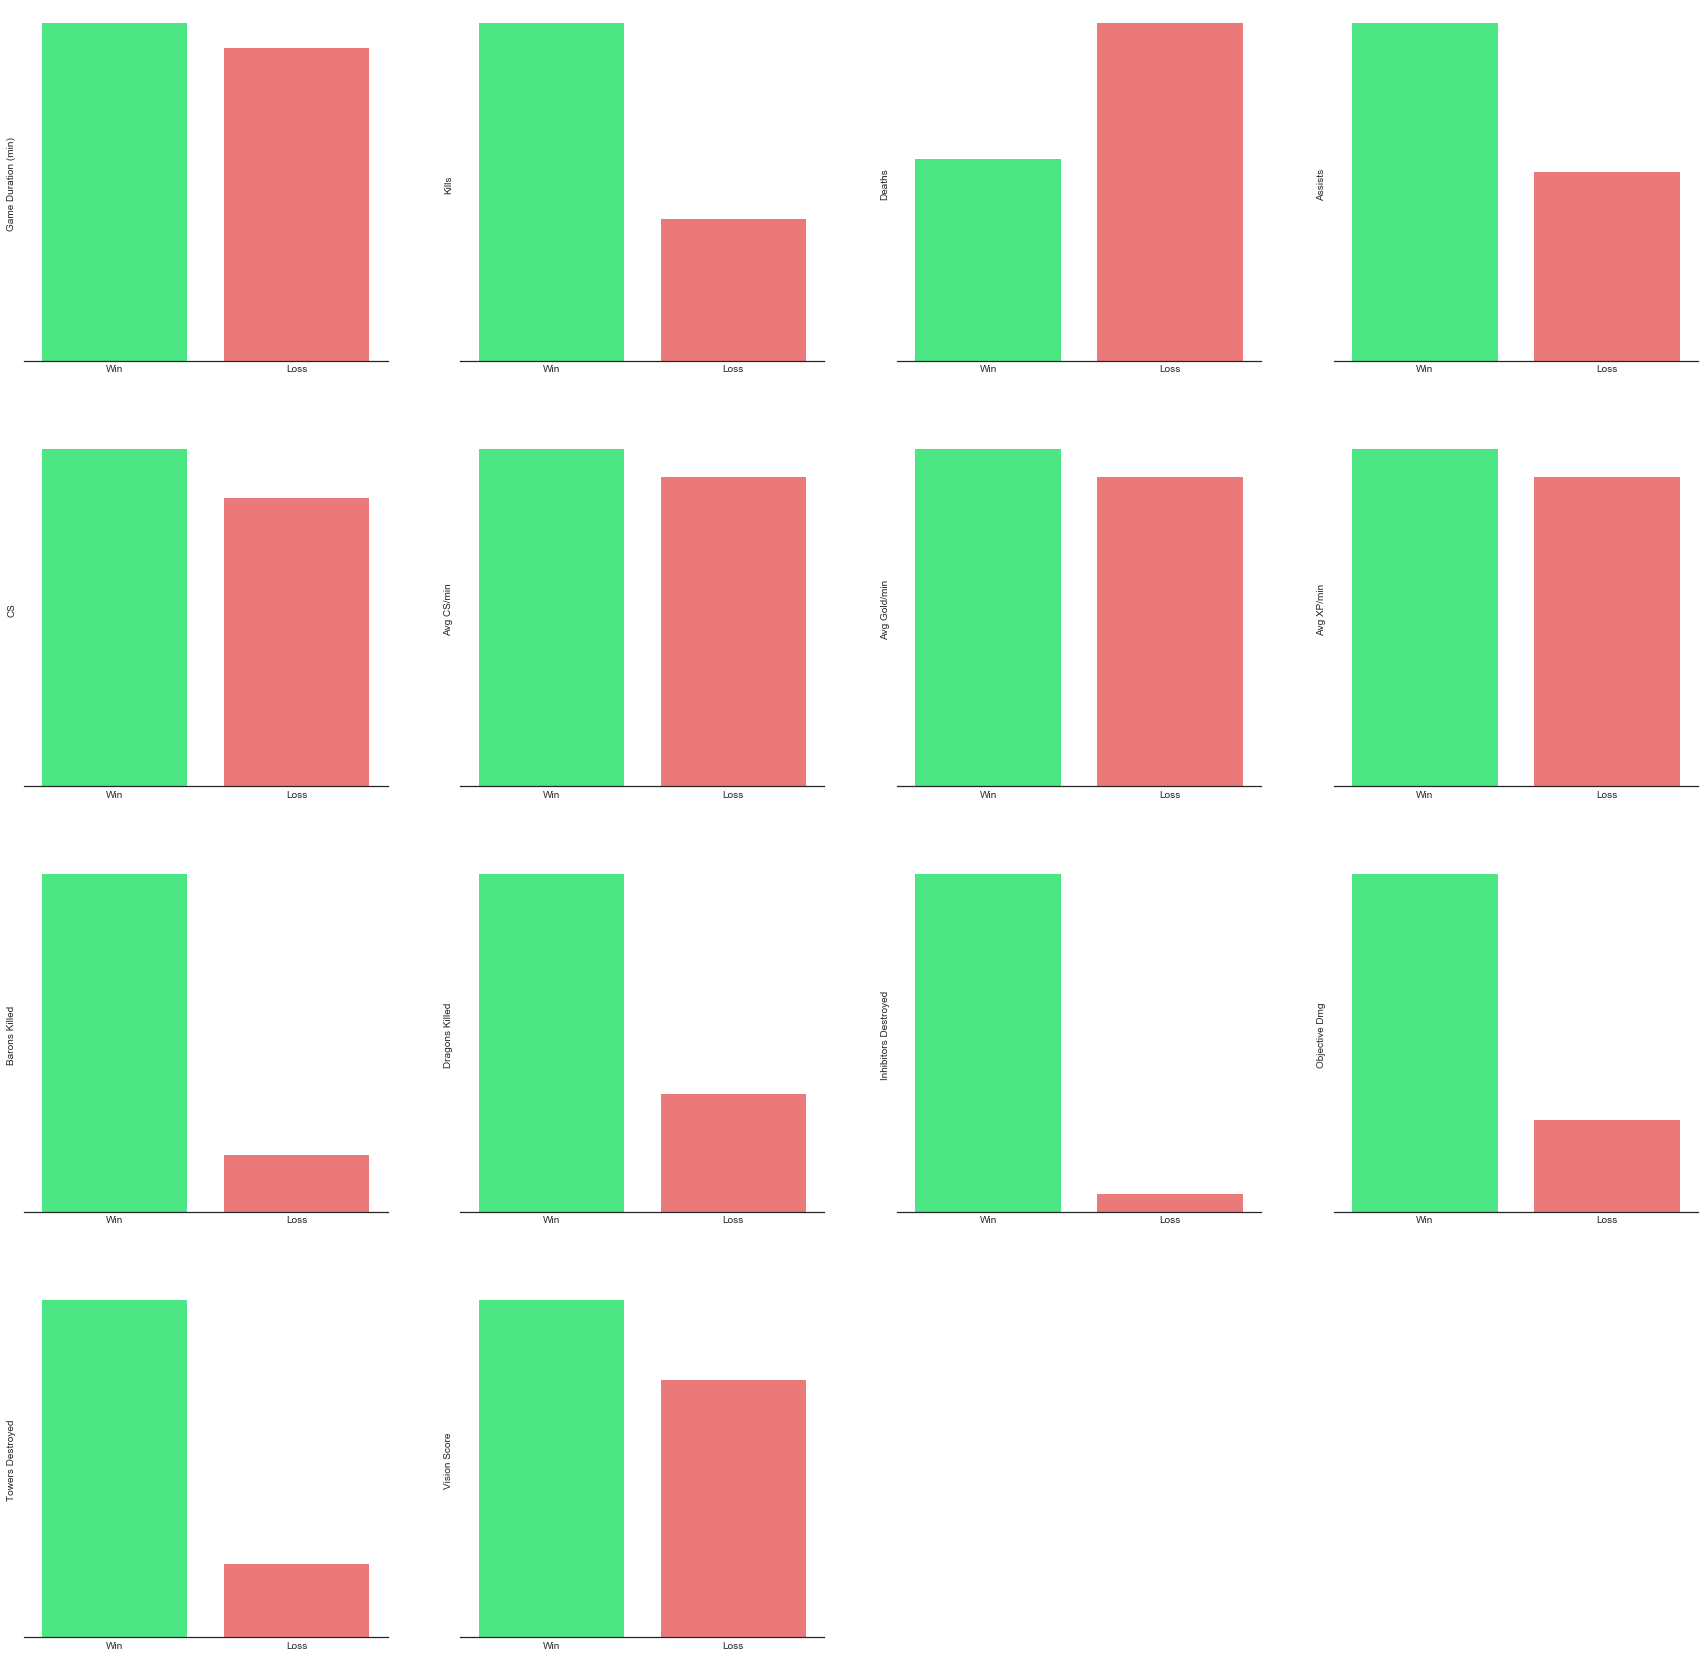

In [29]:
# Evaluate factors that affect match outcome using numeric columns. 

numeric_col = list(my_data.select_dtypes(include=[np.number]).columns.drop(['Game ID','Season ID','Barons Lost','Dragons Lost','Towers Lost','Inhibitors Lost']))
l_green = (51/255,255/255,127/255)
l_red = (255/255,102/255,102/255)
fig = plt.figure(figsize=(30,30))
for i, col in enumerate(numeric_col):
    sns.set_style('white')
    if my_data['Outcome'][0] == 'Win':
        sns.set_palette([l_green,l_red,])
    else:
        sns.set_palette([l_red,l_green])
    ax = fig.add_subplot(4,4,i+1)
    sns.barplot(my_data['Outcome'],my_data[col],ci=None)
    sns.despine(top=True,right=True,left=True,bottom=False)
    plt.xlabel('')
    ax.set_yticklabels([''])
plt.savefig('Wins v Losses')
plt.show()

## Factors that affect objective control

In [30]:
objectives = ['Barons Killed','Dragons Killed','Towers Destroyed','Inhibitors Destroyed','Objective Dmg','Game Duration (min)']
obj_corr = my_data[numeric_col].corr()[objectives]
for col in objectives[:5]:
    print(col+' -', 'Correlates highest with: '+list(obj_corr[obj_corr[col] == obj_corr.drop(objectives).max()[col]][col].index)[0], ' - Correlation coefficient=',list(obj_corr[obj_corr[col] == obj_corr.drop(objectives).max()[col]][col])[0])

Barons Killed - Correlates highest with: Kills  - Correlation coefficient= 0.521931659534
Dragons Killed - Correlates highest with: Vision Score  - Correlation coefficient= 0.489662366719
Towers Destroyed - Correlates highest with: Kills  - Correlation coefficient= 0.666961691981
Inhibitors Destroyed - Correlates highest with: Kills  - Correlation coefficient= 0.573464778135
Objective Dmg - Correlates highest with: Kills  - Correlation coefficient= 0.689755151184


## Observations
As a Gold V player, it's interesting to note the affect that kills and deaths have on the outcome of a match as compared to other factors. I conducted a similar analysis on a Platinum account and found that kills and deaths had little to no affect on the outcome of the match. It would be interesting to further quantify/test this concept further. Moreover, it would be interesting to expand this analysis to other divisions. 

It also appears that key objectives (towers, barons, dragons, inhibitors) all heavily affect match outcome. Below, I briefly evaluated which factors during my matches most heavily influenced objective control. Unsurprisingly, objective control seems to mildly correlate with kills across the board, suggesting that at my division, kills enable teams to more easily contest and take key objectives.

*Ideas for further analysis:*

    * Evaluate data from different divisions to see if match outcome correlations change from division to division
    * Evaluate categorical data that I haven't included in data analysis
    * Explore machine learning algorithms that can be used to optimize match-up strategies from champion select onward